In [1]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import os
from time import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import keras
from keras import layers
from sklearn.model_selection import KFold
import numpy as np
import keras.backend as K
path = ('/Users/carolinesklaver/Desktop/Capstone/NHANES/data/csv_data/')

import os
os.chdir(path)

SEED = 42

target = 'depressed'

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

In [2]:
#df_raw = pd.read_csv('df_mean_75_ext.csv')
df_raw = pd.read_csv('df_progressive_mlp_ext.csv')

## Get feature types

In [3]:
def var_type(df):
    # input dataframe
    # return continuous, non-continous, and multi-categorical features
 
    cols = df.columns
    cont = []
    non_cont = []
    cat_encode = []
    
    # get continuous variables
    for c in cols:
        if df[c].nunique() > 6:
            cont.append(c)
    
    # non cont is the difference
    non_cont = np.setdiff1d(cols, [cont])
    
    # multi-cat are those greater than 2
    for n in non_cont:
        if df[n].nunique() > 2:
            cat_encode.append(n)
    
    return cont, non_cont, cat_encode
    

## Encode multi-categorical features

In [4]:
def one_hot_encode(df, cat_encode):
    # takes in df and multi-cat features
    # returns df with features that are one-hot-encoded encoded and feature names
    
    cols = df.columns
    e_cols = list(set(cols).intersection(set(cat_encode)))
    df_encode = pd.get_dummies(df, columns=e_cols)
    
    features = np.setdiff1d(df_encode.columns, [target])

    return (df_encode, features)

## Split into training and testing & scale data

In [5]:
import pandas as pd
pd.options.mode.chained_assignment = None 
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

def split_train_test(df, features, cont):
    # take in dataframe
    # output training features and binary target
    # output testing features and binary target
    
    
    # divide into training and testing
    df_raw_train, df_raw_test = train_test_split(df, test_size=0.33, random_state=SEED)
    # Reset the index
    df_raw_train, df_raw_test = df_raw_train.reset_index(drop=True), df_raw_test.reset_index(drop=True)

    # split training into train and validation
    df_train_split, df_raw_val = train_test_split(df_raw_train, test_size=0.2, random_state=SEED)
    # Reset the index
    df_train_split, df_raw_val = df_train_split.reset_index(drop=True), df_raw_val.reset_index(drop=True)

   
    
    # Make a copy of df_raw_train
    df_train = df_train_split.copy(deep=True)
    df_val = df_raw_val.copy(deep=True)
    # Make a copy of df_raw_test
    df_test = df_raw_test.copy(deep=True)


    # get feautre matrix
    x_train = df_train[features]
    x_val = df_val[features]
    x_test = df_test[features]
    
    y_train = df_train[target]
    y_val = df_val[target]
    y_test = df_test[target]
    
    
    # ---------------------- scale the continuous features --------------------
    x_train.astype('float32')
    x_val.astype('float32')
    x_test.astype('float32')

    cont_ss = []
    for var in cont:
        if var in x_train.columns:
            cont_ss.append(var)

    x_train[cont_ss] = ss.fit_transform(x_train[cont_ss])
    x_val[cont_ss] =ss.fit_transform(x_val[cont_ss])
    x_test[cont_ss] = ss.transform(x_test[cont_ss])
    # ---------------------------------------------------------------------------
    
    # get 2D output shape
    y_train_binary = keras.utils.to_categorical(y_train)
    y_val_binary = keras.utils.to_categorical(y_val)
    y_test_binary = keras.utils.to_categorical(y_test)
    
    # get input dimentions
    input_n = df_train.shape[1]-1

    print('Training data shape:', df_train.shape)
    print('Val data shape:', df_val.shape)
    print('Test data shape:', df_test.shape)
    print('Input shape:', input_n)
    
    
    return x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n



# Keras NN Model

In [6]:
def keras_model(input_n):

    # Define the model architecture
    model = keras.Sequential()

    model.add(layers.Dense(200, activation='relu' , input_dim=input_n))
    model.add(Dropout(0.2))
    model.add(layers.Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(60, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(60, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(2, activation='softmax'))

    # print(model.summary())

    return model

In [7]:
import keras
from keras import layers
from sklearn.model_selection import KFold
import numpy as np
import keras.backend as K
K.clear_session()
tf.config.experimental.set_visible_devices([], 'GPU')

# --------------------------------------- Plots ---------------------------------------
from matplotlib import pyplot as plt

def acc_loss_plots(hist):
    # list all data in history
    print(hist.history.keys())
    # summarize history for accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [8]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score


# Define the K-fold Cross Validator
BATCH_SIZE=32
EPOCHS_1 = 25
num_folds=2

def nn_kfold(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    inputs = np.concatenate((x_train, x_val), axis=0)
    targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):

        model = keras_model(input_n)
        
        if fold_no==1:
            print(model.summary())

        opt = keras.optimizers.rmsprop()

        model.compile(loss='binary_crossentropy',
                  optimizer=opt,metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        if balanced_batches==True:
            training_generator, steps_per_epoch = balanced_batch_generator(inputs[train],targets[train],
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
            history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(inputs[test], targets[test]),
                                    epochs=EPOCHS_1, verbose=0)

        else:
            history = model.fit(inputs[train],targets[train], #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(inputs[test], targets[test]),
                        epochs=EPOCHS_1, verbose=0)



        # Generate generalization metrics
        scores = model.evaluate(inputs[test], targets[test], verbose=1)
        
        # Generate a print
        print('------------------------------------------------------------------------')
        print(
        f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; '
        f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
        f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
        # plot Testing/Val accuracy and loss    
        if fold_no==num_folds:
            # plot the accuracy and loss for training/val by epoch
            acc_loss_plots(history)


        # Increase fold number
        fold_no = fold_no + 1
        
        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model



# CNN model

In [9]:
from __future__ import print_function    
from keras.models import Sequential
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

def cnn_model(input_n):
    model = Sequential()
    model.add(layers.Reshape((input_n,1), input_shape=(input_n,)))
    model.add(Conv1D(32, (2), input_shape=(input_n,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(32, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv1D(64, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))


    # print(model.summary())
    
    return model

In [10]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

BATCH_SIZE=32
EPOCHS_2 = 5

def cnn(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    # inputs = np.concatenate((x_train, x_val), axis=0)
    # targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    model = cnn_model(input_n)
    print(model.summary())

    opt = keras.optimizers.Adam()

    model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

    # Generate a print
    print('------------------------------------------------------------------------')

    if balanced_batches==True:
        training_generator, steps_per_epoch = balanced_batch_generator(x_train, y_train_binary,
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
        history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(x_val, y_val_binary),
                                    epochs=EPOCHS_2, verbose=1)

    else:
        history = model.fit(x_train, y_train_binary, #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(x_val, y_val_binary),
                        epochs=EPOCHS_2, verbose=1)



    # Generate generalization metrics
    scores = model.evaluate(x_val, y_val_binary, verbose=1)
        
    # Generate a print
    print('------------------------------------------------------------------------')
    print(
    f'Score for val cnn: {model.metrics_names[0]} of {scores[0]}; '
    f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
    f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
    # plot Testing/Val accuracy and loss    
    acc_loss_plots(history)

        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model

## Different target = 'overweight'

In [31]:
target = 'doc_overweight'
cont, non_cont, cat_encode = var_type(df_raw)

In [20]:
neg, pos = np.bincount(df_raw[target])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 31357
    Positive: 10595 (33.79% of total)



Training data shape: (16807, 167)
Val data shape: (4202, 167)
Test data shape: (10348, 167)
Input shape: 166
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 200)               33400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
___________

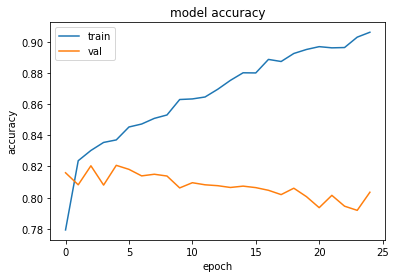

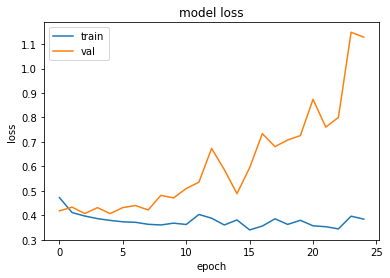

[[5832 1001]
 [1006 2509]]
F1 score: 0.714306049822064
Precision: 0.7148148148148148
Recall: 0.7137980085348506
Accuracy: 0.8060494781600309
ROC AUC: 0.7836515287808162


In [14]:
nn_kfold(df_raw)

Training data shape: (16807, 167)
Val data shape: (4202, 167)
Test data shape: (10348, 167)
Input shape: 166
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 166, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 165, 32)           96        
_________________________________________________________________
batch_normalization_11 (Batc (None, 165, 32)           128       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 164, 32)           2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 164, 32)           128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 163, 64)           4160      
___________

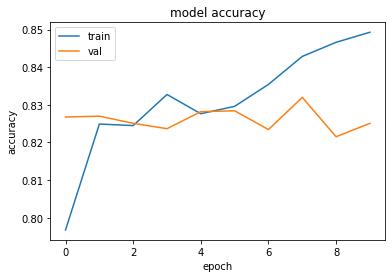

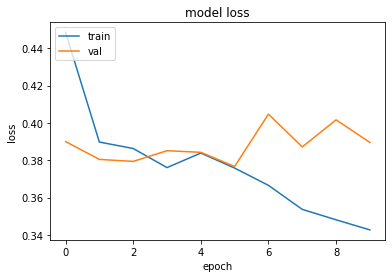

[[6070  763]
 [1021 2494]]
F1 score: 0.7365623154164206
Precision: 0.7657353392692662
Recall: 0.7095305832147938
Accuracy: 0.8275995361422497
ROC AUC: 0.7989332998029186


In [32]:
EPOCHS_2 = 10
cnn(df_raw)

## UCI Breast Cancer data

In [11]:
breast_cancer = pd.read_csv('breast_cancer_data.csv')
breast_cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [12]:
# change overtime to 1 if over, 0 if not
breast_cancer['diagnosis'].values[breast_cancer['diagnosis']=='M'] = 1
breast_cancer['diagnosis'].values[breast_cancer['diagnosis']=='B'] = 0

In [13]:
neg, pos = np.bincount(breast_cancer['diagnosis'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 569
    Positive: 212 (37.26% of total)



In [14]:
target = 'diagnosis'

breast_cancer.drop(['Unnamed: 32'],axis=1, inplace=True)
breast_cancer.drop(['id'],axis=1, inplace=True)

cont, non_cont, cat_encode = var_type(breast_cancer)

Training data shape: (304, 31)
Val data shape: (77, 31)
Test data shape: (188, 31)
Input shape: 30
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 200)               6200      
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
_____________________

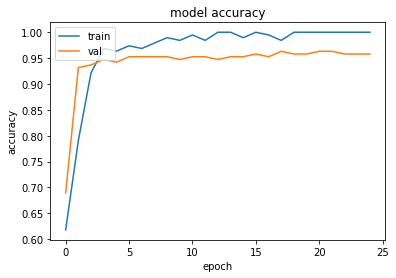

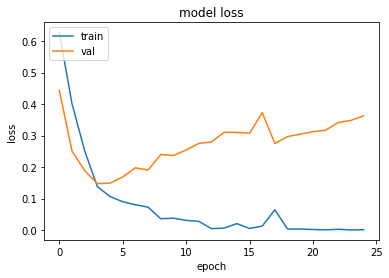

[[105  16]
 [  1  66]]
F1 score: 0.8859060402684563
Precision: 0.8048780487804879
Recall: 0.9850746268656716
Accuracy: 0.9095744680851063
ROC AUC: 0.926421610953497


In [28]:
nn_kfold(breast_cancer)

Training data shape: (304, 31)
Val data shape: (77, 31)
Test data shape: (188, 31)
Input shape: 30
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 30, 1)             0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 29, 32)            96        
_________________________________________________________________
batch_normalization_41 (Batc (None, 29, 32)            128       
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 28, 32)            2080      
_________________________________________________________________
batch_normalization_42 (Batc (None, 28, 32)            128       
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 27, 64)            4160      
_____________________

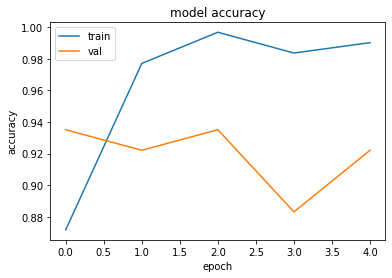

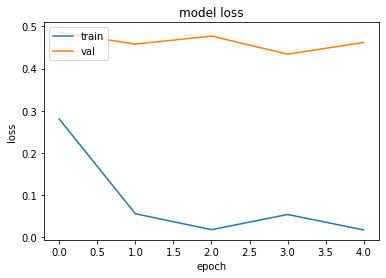

[[119   2]
 [  9  58]]
F1 score: 0.9133858267716535
Precision: 0.9666666666666667
Recall: 0.8656716417910447
Accuracy: 0.9414893617021277
ROC AUC: 0.924571358085605


In [23]:
cnn(breast_cancer)